Preprocessing in Excel:
    1. Remove rows 1-3
    2. Remove average, min, max rows at end of file
    3. Export as csv

In [1]:
import pandas as pd
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']

In [3]:
# reads from csv into a new dataframe
raw = pd.read_csv('energy_raw.csv',index_col=0,na_values=['#########'])

# reindexes by appropriate datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# removes built-in demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# renames columns accordingly
raw.columns = buildingnames

In [4]:
# removes Davenport, for this example only, because its missing a few weeks of data
# raw = raw.drop('Davenport',axis=1)

# saves first five rows to replace later
first_rows = raw.head(5)
first_rows

YUAG   Berkeley     Hopper     304Elm  Davenport  \
2018-01-01 00:00:00  7929946.5  7241231.2  2766963.5  1109119.8  4306847.8   
2018-01-01 01:00:00  7930103.6  7241300.8  2767051.1  1109124.4  4306942.8   
2018-01-01 02:00:00  7930256.8  7241359.7  2767125.7  1109129.0  4307035.7   
2018-01-01 03:00:00  7930426.2  7241423.3  2767205.3  1109133.8  4307137.8   
2018-01-01 04:00:00  7930598.0  7241486.5  2767284.2  1109138.8  4307237.7   

                          38HH  320Temple     53Wall   Sprague     Malone  \
2018-01-01 00:00:00  3164052.8    94018.2  3024576.8  358345.5  6543549.3   
2018-01-01 01:00:00  3164055.9    94019.9  2493806.4  358379.5  6543660.7   
2018-01-01 02:00:00  3164058.5    94021.8  3024609.2  358411.2  6543770.8   
2018-01-01 03:00:00  3164061.8    94023.8  3024625.3  358443.5  6543892.0   
2018-01-01 04:00:00  3164065.0    94025.7  3024641.7  358475.8  6544010.3   

                      Trumbull       17HH  
2018-01-01 00:00:00  4441711.2  8929603.5  
2018-01-01 01:00:00  4441765.7  7419481.4  
2018-01-01 02:00:00  4441818.0  8929905.7  
2018-01-01 03:00:00  4441878.8  8930055.8  
2018-01-01 04:00:00  4441940.3  8930205.0

In [5]:
# this cell removes impossible outliers based on the percent change, limited by tau
raw = raw.where(raw.pct_change(limit=1)>0)

tau = 0.0005
raw = raw.where(raw.pct_change(limit=1)<tau)

raw.iloc[[0,1,2,3,4],:] = first_rows

raw.isnull().sum()

YUAG         124
Berkeley       4
Hopper         4
304Elm       124
Davenport    907
38HH           4
320Temple    135
53Wall       226
Sprague        5
Malone       124
Trumbull     189
17HH         269
dtype: int64

In [6]:
# Diagnostic cell
# fn.snapshotplot(raw,'Davenport','2018-01-02 00:00:00','2018-07-25 00:00:00')
# raw.head(10)

In [7]:
# interpolates small ranges of missing consumption data (less than 6 hours)
raw = raw.interpolate(method='time',limit=6,limit_area='inside')

fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
raw.isnull().sum()

YUAG           9
Berkeley       0
Hopper         0
304Elm         9
Davenport    903
38HH           0
320Temple     11
53Wall        10
Sprague        0
Malone         9
Trumbull      10
17HH          10
dtype: int64

In [8]:
# creates a new dataframe for the demand values, drops the first row
raw_demand = raw.diff().drop(raw.index[0])

demand = raw_demand.copy(deep=True)

YUAG          12
Berkeley       0
Hopper         0
304Elm        12
Davenport    903
38HH           0
320Temple     15
53Wall        13
Sprague        0
Malone        12
Trumbull      13
17HH          13
dtype: int64

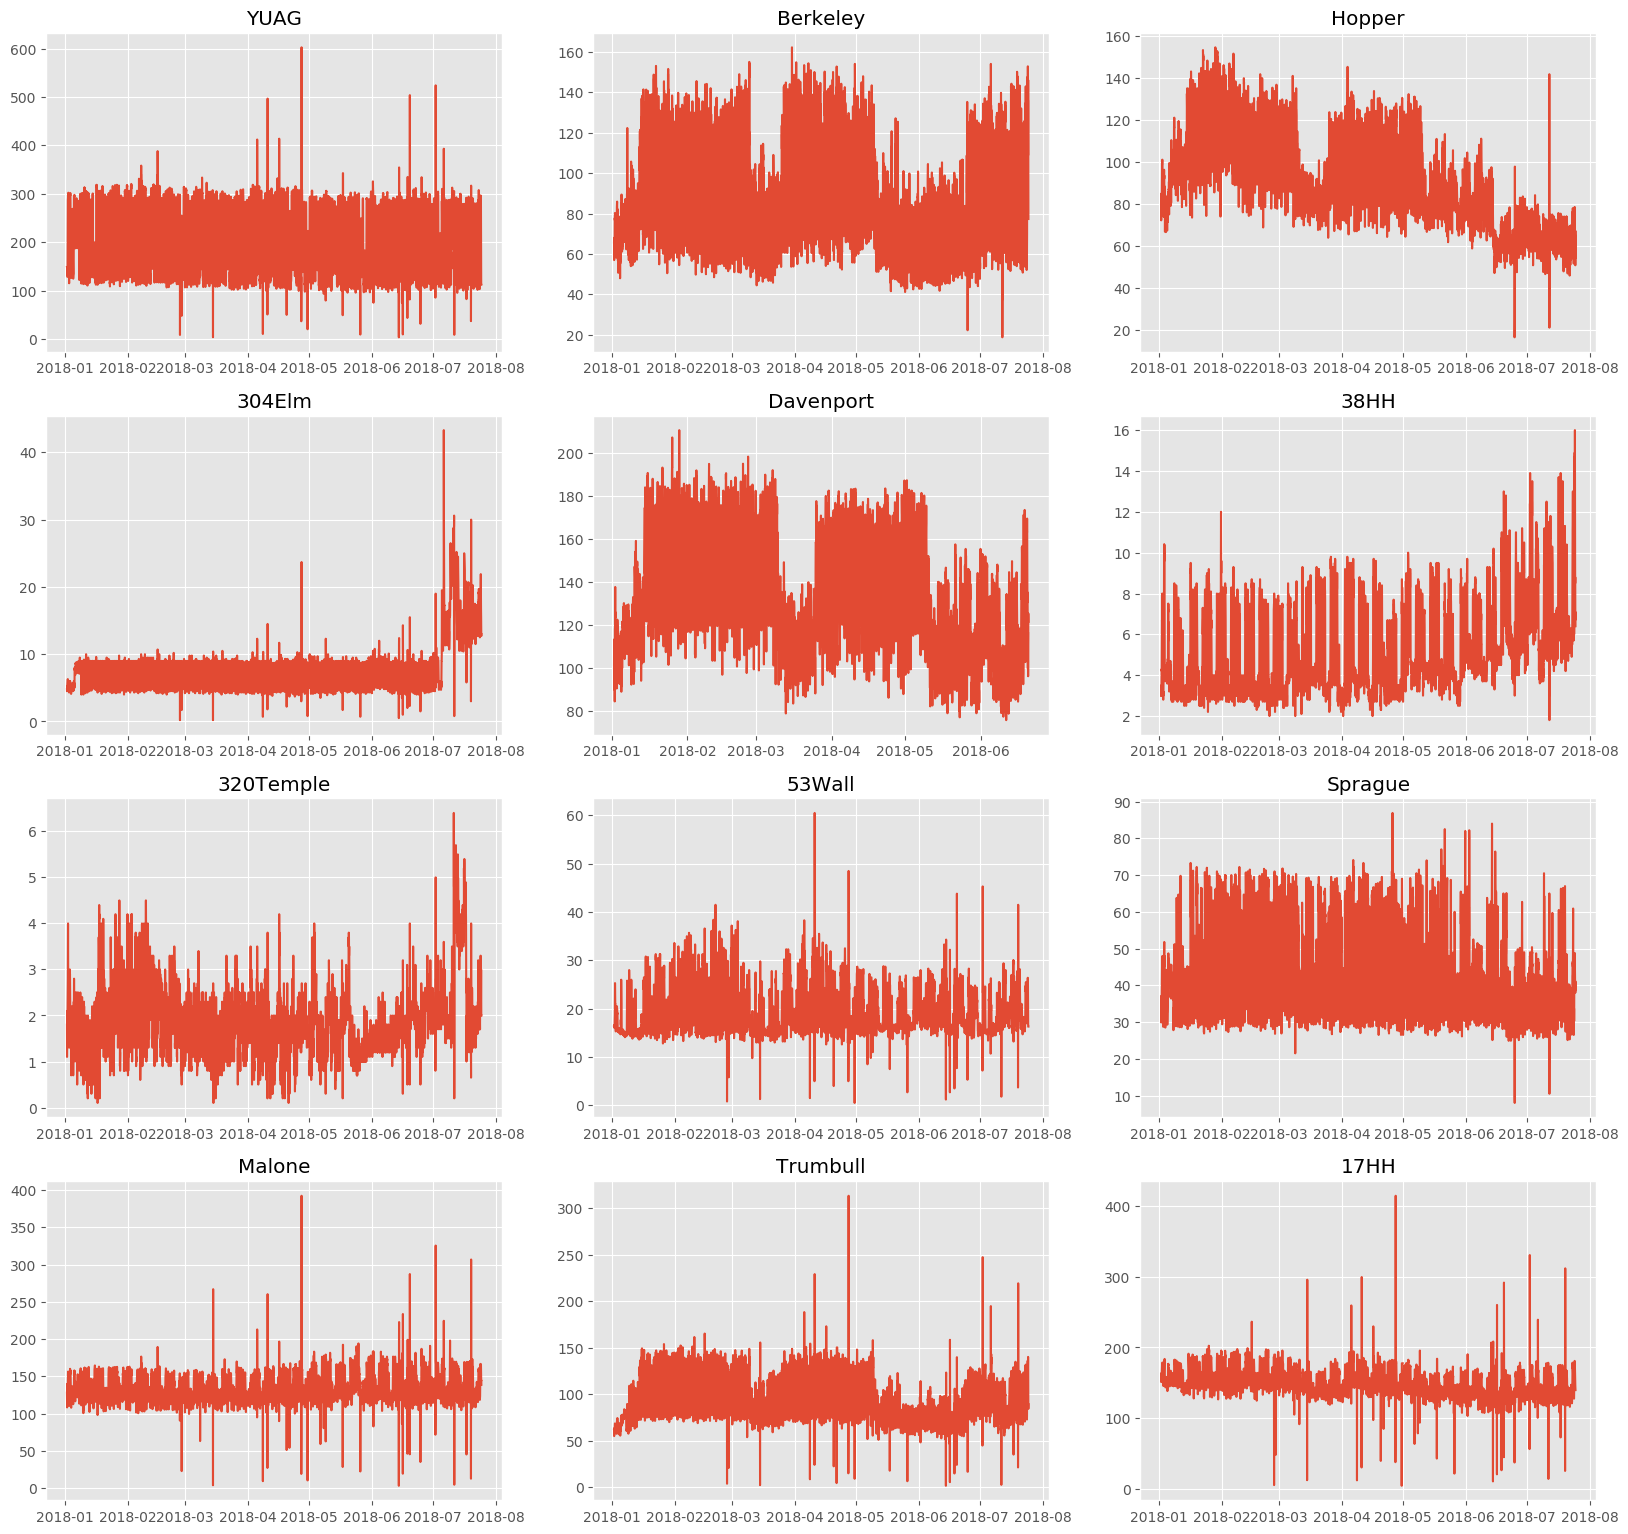

In [9]:
fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
demand.isnull().sum()

In [10]:
# demand = demand.where(demand > demand.quantile(q=0.1)-(lower*demand.std()))

# print(demand.median())
# print(demand.std())
# demand.quantile(q=0.1)

# demand.rolling(3).median()

demand

YUAG  Berkeley  Hopper  304Elm  Davenport  38HH  \
2018-01-01 01:00:00  157.1      69.6    87.6     4.6       95.0   3.1   
2018-01-01 02:00:00  153.2      58.9    74.6     4.6       92.9   2.6   
2018-01-01 03:00:00  169.4      63.6    79.6     4.8      102.1   3.3   
2018-01-01 04:00:00  171.8      63.2    78.9     5.0       99.9   3.2   
2018-01-01 05:00:00  172.2      63.0    79.0     4.9      101.0   3.0   
2018-01-01 06:00:00  168.8      63.5    80.6     5.0      100.8   3.0   
2018-01-01 07:00:00  168.8      63.0    78.7     5.0      100.8   3.5   
2018-01-01 08:00:00  172.2      69.8    80.0     4.6      101.5   3.0   
2018-01-01 09:00:00  201.0      78.7    80.5     5.2       99.5   3.0   
2018-01-01 10:00:00  245.8      78.3    78.0     5.3      100.0   3.0   
2018-01-01 11:00:00  222.4      77.7    77.8     4.5      100.9   3.2   
2018-01-01 12:00:00  220.1      78.0    81.0     5.9      102.8   3.3   
2018-01-01 13:00:00  220.7      78.0    78.4     5.0      105.0   2.7   
2018-01-01 14:00:00  198.0      78.5    78.5     4.8      105.2   3.3   
2018-01-01 15:00:00  196.3      78.7    77.8     5.0      106.6   3.0   
2018-01-01 16:00:00  197.0      79.3    74.7     4.8      106.2   3.3   
2018-01-01 17:00:00  197.5      78.7    76.8     5.0      102.2   3.2   
2018-01-01 18:00:00  197.2      79.0    81.7     4.9      102.6   3.5   
2018-01-01 19:00:00  178.2      77.8    80.0     5.0      104.7   3.5   
2018-01-01 20:00:00  148.8      72.5    79.1     4.6      103.2   3.5   
2018-01-01 21:00:00  148.7      72.3    80.2     4.9      108.1   3.0   
2018-01-01 22:00:00  147.3      66.9    80.8     4.8      110.7   3.0   
2018-01-01 23:00:00  147.2      64.1    79.2     5.0      102.7   3.5   
2018-01-02 00:00:00  148.6      65.7    78.8     4.8      101.1   3.0   
2018-01-02 01:00:00  147.9      68.0    85.1     4.5      113.1   3.5   
2018-01-02 02:00:00  145.1      57.0    72.4     5.2       96.9   3.0   
2018-01-02 03:00:00  147.4      64.3    80.2     5.0       96.2   3.0   
2018-01-02 04:00:00  129.3      64.0    77.3     4.8       89.7   3.0   
2018-01-02 05:00:00  128.2      63.2    77.9     5.0      106.3   3.7   
2018-01-02 06:00:00  128.3      63.7    77.1     4.9      102.2   4.0   
...                    ...       ...     ...     ...        ...   ...   
2018-07-26 18:00:00  288.1     111.5    61.5    12.3        NaN  12.5   
2018-07-26 19:00:00  255.9     119.5    66.7    12.7        NaN  10.0   
2018-07-26 20:00:00  197.3     109.3    62.7    11.0        NaN   8.7   
2018-07-26 21:00:00  166.5     117.7    71.5     9.0        NaN   8.5   
2018-07-26 22:00:00  119.7      84.1    60.6     8.8        NaN   7.3   
2018-07-26 23:00:00  114.8      78.0    67.5     8.2        NaN   7.8   
2018-07-27 00:00:00  113.5      60.5    57.0     8.3        NaN   7.5   
2018-07-27 01:00:00  120.0      68.1    69.8     8.4        NaN   8.1   
2018-07-27 02:00:00  101.8      53.6    60.1     7.3        NaN   6.4   
2018-07-27 03:00:00  113.0      63.3    75.5     8.2        NaN   7.4   
2018-07-27 04:00:00  133.7      50.7    60.6     8.6        NaN   6.8   
2018-07-27 05:00:00  114.5      60.3    71.2     8.9        NaN   7.2   
2018-07-27 06:00:00  114.7      50.7    59.0     8.0        NaN   7.0   
2018-07-27 07:00:00  129.8      84.3    75.0     9.3        NaN   6.6   
2018-07-27 08:00:00  150.0     101.4    63.7    12.7        NaN   6.5   
2018-07-27 09:00:00  191.5     136.1    68.8    14.1        NaN   8.5   
2018-07-27 10:00:00  251.0     128.4    60.7    13.7        NaN   9.2   
2018-07-27 11:00:00  279.7     139.8    74.1    14.0        NaN  12.0   
2018-07-27 12:00:00  287.0     122.5    71.2    13.8        NaN  10.0   
2018-07-27 13:00:00  290.8     130.7    70.3    13.4        NaN  12.5   
2018-07-27 14:00:00  290.7     131.0    64.0    13.3        NaN  12.0   
2018-07-27 15:00:00  292.3     140.3    65.0    12.8        NaN  13.3   
2018-07-27 16:00:00  292.8     130.3    72.9    12.4        NaN  11.9   
2018-07

YUAG           60
Berkeley     1172
Hopper       1149
304Elm       1962
Davenport    1979
38HH          410
320Temple    1001
53Wall         15
Sprague      1233
Malone        768
Trumbull     1169
17HH           15
dtype: int64

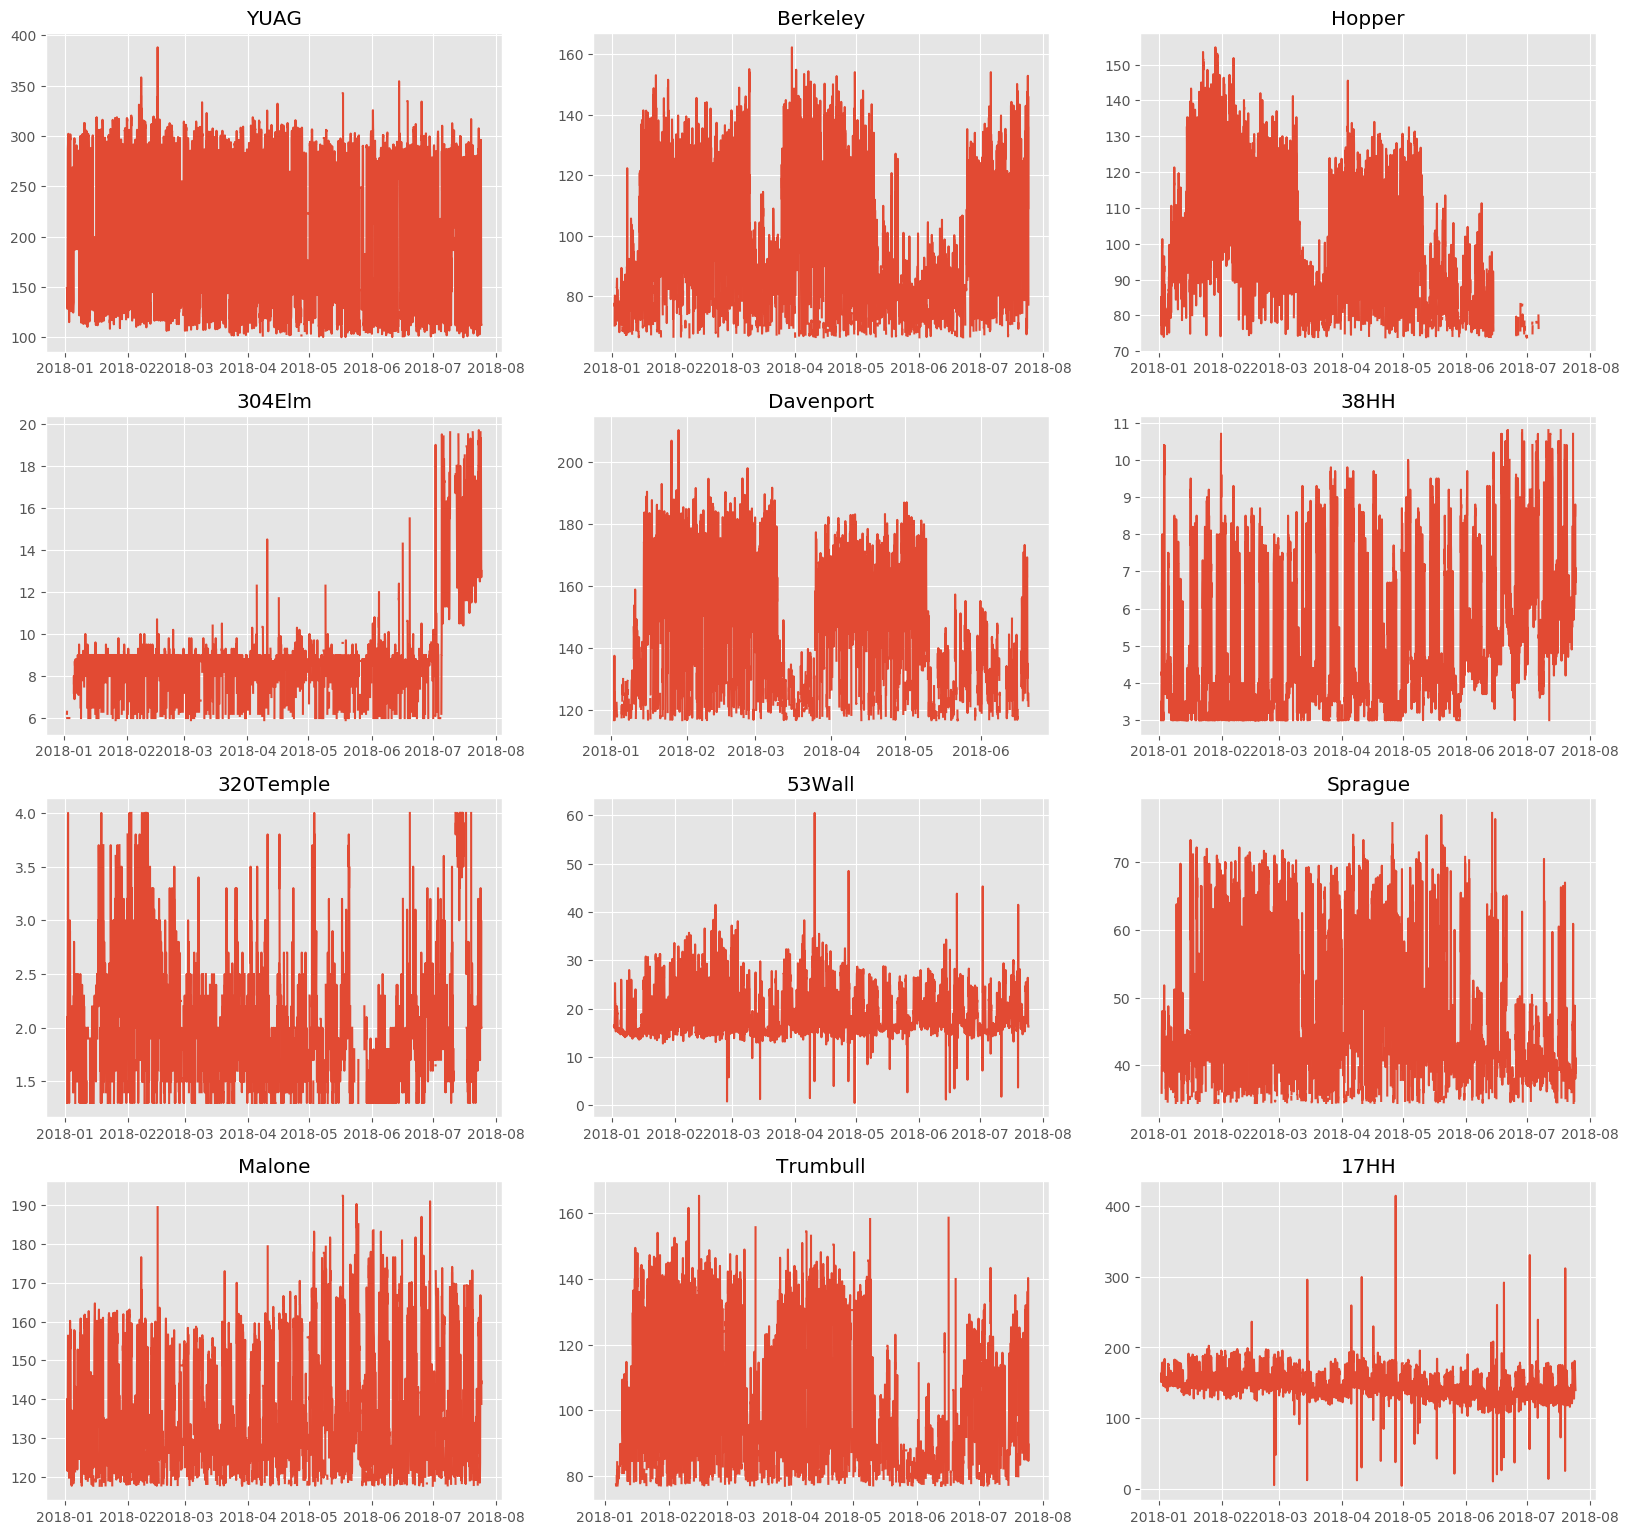

In [11]:
# another stab at this
lower=1
upper=3

# demand = demand.where(demand > demand.quantile(q=0.1)-(lower*demand.std()))

# demand = demand.where(demand > demand.median()-(lower*demand.std()))

# demand = demand.where(demand < demand.median()+(upper*demand.std()))


# removes strong statistical outliers
lower=0.7
upper=3
demand = demand.where(demand > demand.median()-(lower*demand.std())).where(demand < demand.median()+(upper*demand.std()))

fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
demand.isnull().sum()

In [12]:
print(demand.median())
print(demand.std())
demand.quantile(q=0.1)

YUAG         155.65
Berkeley      97.00
Hopper        98.30
304Elm         8.80
Davenport    152.00
38HH           4.70
320Temple      2.00
53Wall        17.90
Sprague       46.40
Malone       135.70
Trumbull     106.00
17HH         148.80
dtype: float64
YUAG         77.173864
Berkeley     22.771465
Hopper       18.248355
304Elm        2.483880
Davenport    20.765474
38HH          1.896989
320Temple     0.562255
53Wall        5.018120
Sprague      10.700674
Malone       16.031893
Trumbull     20.482409
17HH         20.878817
dtype: float64


YUAG         113.40
Berkeley      71.80
Hopper        78.80
304Elm         7.50
Davenport    120.90
38HH           3.20
320Temple      1.40
53Wall        14.85
Sprague       36.80
Malone       120.70
Trumbull      81.40
17HH         127.70
Name: 0.1, dtype: float64

YUAG           60
Berkeley     1172
Hopper       1149
304Elm       1962
Davenport    1979
38HH          410
320Temple    1001
53Wall         15
Sprague      1233
Malone        768
Trumbull     1169
17HH           15
dtype: int64

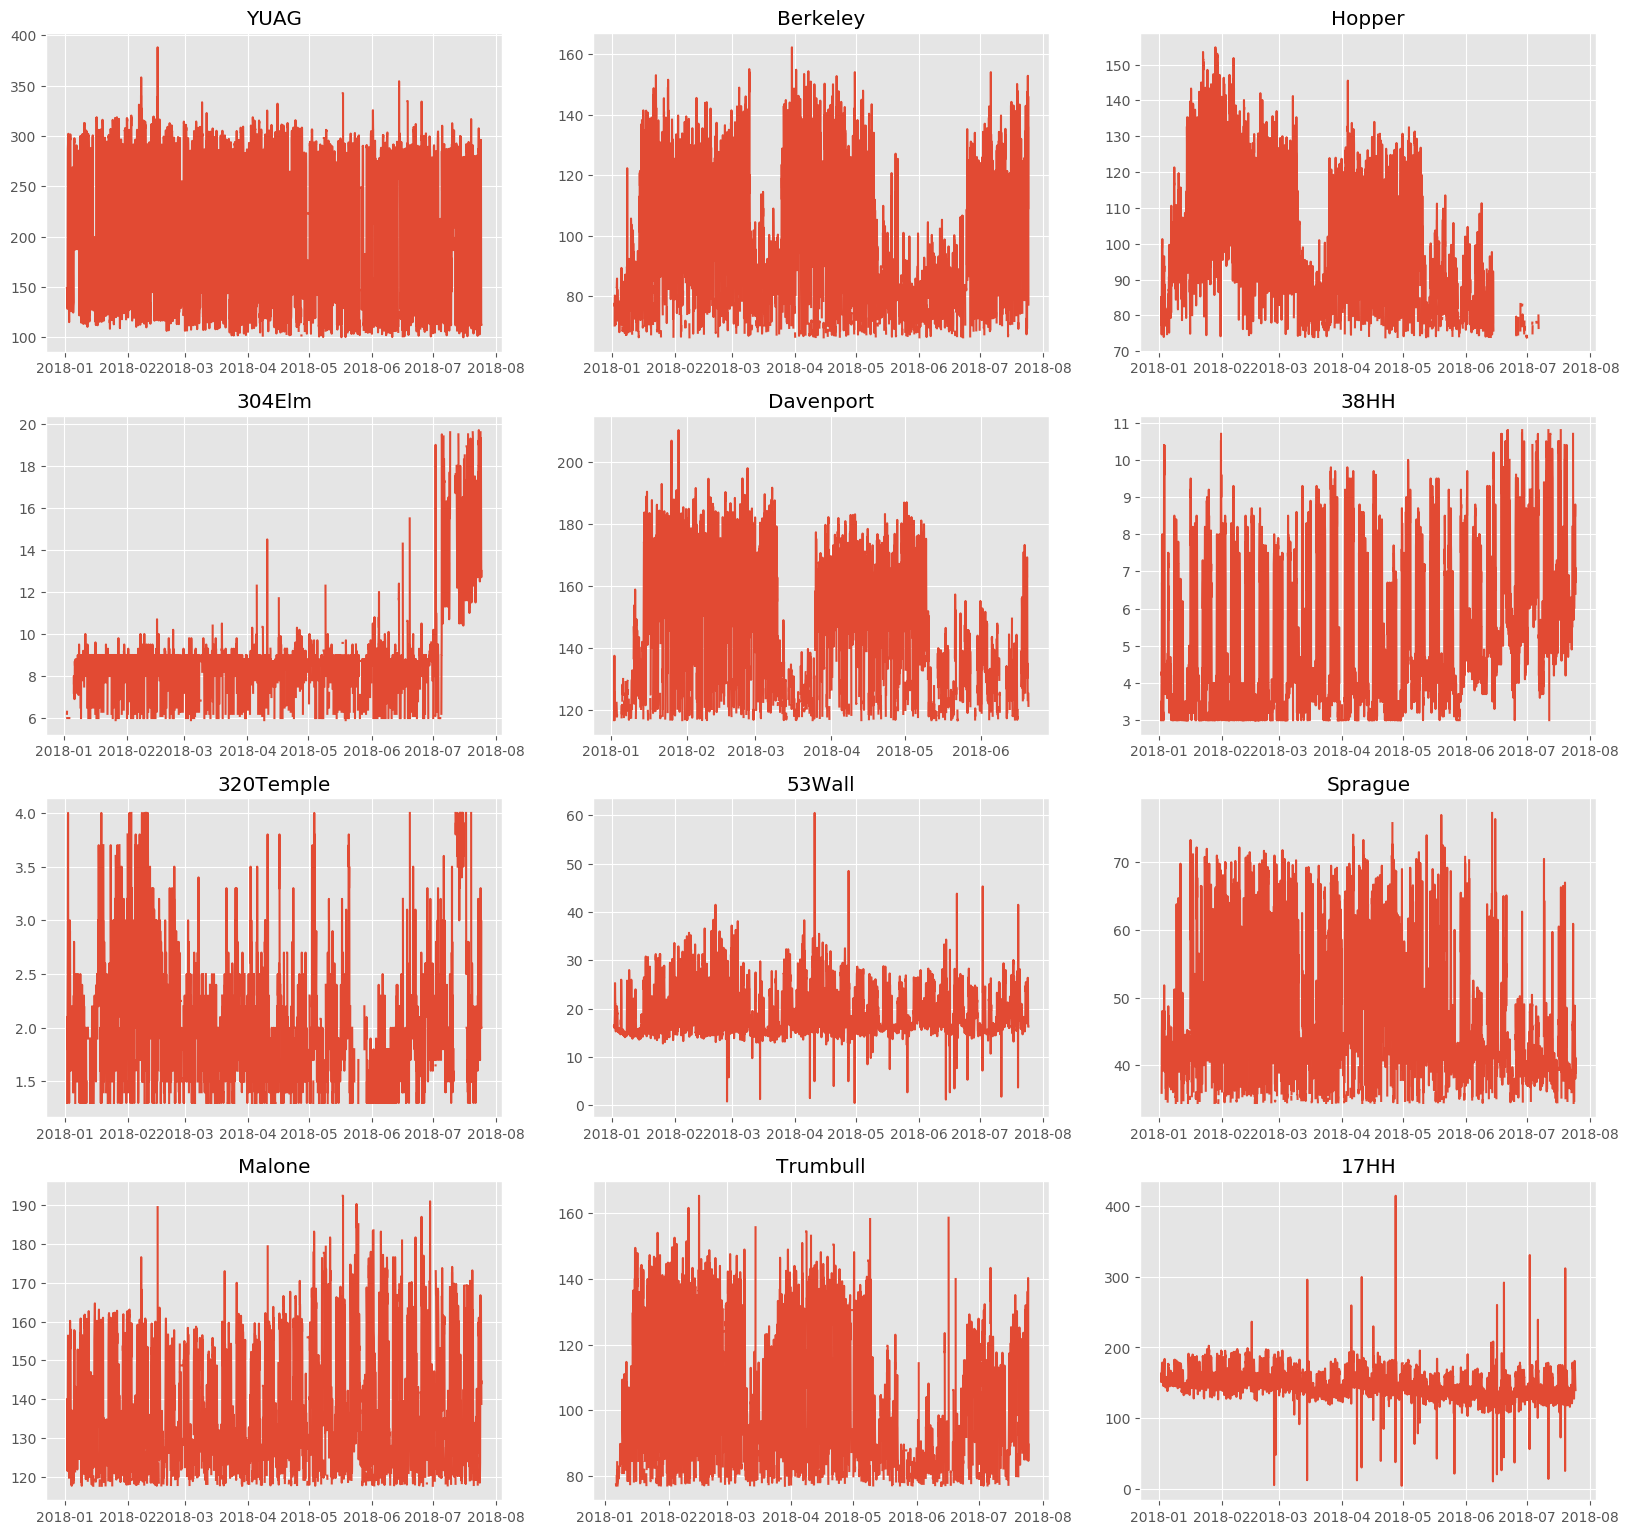

In [13]:
fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
demand.isnull().sum()

In [14]:
demand.describe()

YUAG     Berkeley       Hopper       304Elm    Davenport  \
count  4930.000000  3818.000000  3841.000000  3028.000000  3011.000000   
mean    193.551927   100.604191   101.116793     9.378542   149.723613   
std      77.173864    22.771465    18.248355     2.483880    20.765474   
min      99.900000    66.500000    73.900000     5.900000   116.700000   
25%     122.200000    80.500000    85.300000     8.500000   129.700000   
50%     155.650000    97.000000    98.300000     8.800000   152.000000   
75%     283.000000   120.400000   116.000000     9.000000   167.100000   
max     388.000000   162.200000   154.800000    19.700000   210.400000   

              38HH    320Temple       53Wall      Sprague       Malone  \
count  4580.000000  3989.000000  4975.000000  3757.000000  4222.000000   
mean      5.268057     2.038405    19.522587    49.636998   139.652582   
std       1.896989     0.562255     5.018120    10.700674    16.031893   
min       3.000000     1.300000     0.500000    34.400000   117.700000   
25%       3.700000     1.600000    15.700000    41.200000   125.800000   
50%       4.700000     2.000000    17.900000    46.400000   135.700000   
75%       6.700000     2.300000    23.000000    59.200000   153.475000   
max      10.800000     4.000000    60.500000    77.300000   192.425000   

          Trumbull         17HH  
count  3821.000000  4975.000000  
mean    107.743563   150.580071  
std      20.482409    20.878817  
min      76.900000     4.300000  
25%      88.600000   137.000000  
50%     106.000000   148.800000  
75%     126.500000   163.350000  
max     165.400000   414.700000

In [15]:
# final interpolation of demand values after dropping outliers
# this needs to be replaced with FFT for any gaps longer than ~6 hours
demand = demand.interpolate(method='time',limit=6)

# replaces mistakenly deleted values from pct_change calculation
demand.iloc[[0,1,2,3],:] = raw_demand.iloc[[0,1,2,3],:].values

print(demand.isnull().sum())

# returns index labels where nan values appear for a certain column
nan_index = demand['304Elm'].index[demand['304Elm'].apply(np.isnan)]
print(nan_index)

YUAG            0
Berkeley      176
Hopper        659
304Elm        757
Davenport    1240
38HH           21
320Temple     183
53Wall          0
Sprague       158
Malone         32
Trumbull      294
17HH            0
dtype: int64
DatetimeIndex(['2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               '2018-01-01 11:00:00', '2018-01-01 19:00:00',
               '2018-01-01 20:00:00', '2018-01-01 21:00:00',
               ...
               '2018-07-12 02:00:00', '2018-07-12 03:00:00',
               '2018-07-12 14:00:00', '2018-07-12 15:00:00',
               '2018-07-12 16:00:00', '2018-07-12 17:00:00',
               '2018-07-12 18:00:00', '2018-07-16 17:00:00',
               '2018-07-16 18:00:00', '2018-07-25 17:00:00'],
              dtype='datetime64[ns]', length=757, freq=None)


In [16]:
# removes Trumbull and 17HH if I want to ignore them due to sensor errors
# final = demand.drop(['Trumbull','17HH'],axis=1)

final = final.round(1)

final.to_csv('energy_clean.csv')

NameError: name 'final' is not defined

# unused code below

In [ ]:
# # this cell removes all consumption values BELOW first value

# # creates dataframe of repeated minimum (first) values, pretty workaroundy
# raw_mins = raw.copy(deep=True)
# raw_mins.loc[:,:] = raw.loc['2018-01-01 00:00:00'].values

# # sets all violating values to NaN
# raw = raw.where(raw >= raw_mins)

# # this unused line was an attempt to find outliers using std ranges
# # raw = raw.where(raw > raw.median() - 2*raw.std()).where(raw < raw.median() + 2*raw.std())

# raw.isnull().sum()

In [ ]:
# trying to plot daily average curves for buildings... matplotlib might support this somehow or i can write a fn

# raw = raw.iloc[:,[0]]

# raw['day'] = raw.index.day
# raw['hour'] = raw.index.hour

# raw_by_day = raw.resample('h').mean()
# raw_by_day = raw_by_day.set_index(['day','hour']).unstack('day')
# raw_by_day